In [1]:
import csv
import re
import pandas as pd
import numpy as np
import math
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.convolution import convolve, Gaussian2DKernel
import astropy.constants as const
from matplotlib import colors
import matplotlib.cm as cm
from matplotlib import ticker
import scipy.misc
import scipy.stats as sta
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval,LinearStretch,ImageNormalize
get_ipython().magic('matplotlib inline')
import plotly.graph_objects as go
import plotly
from astropy.cosmology import WMAP9 as cosmo
from pandas.core.frame import DataFrame
from scipy.optimize import curve_fit
from scipy import integrate
import seaborn as sns
import pyraf
from pyraf import iraf

In [2]:
listbins=np.arange(0, 3.1, 0.1)
listlabels=[]
for i in range(len(listbins)-1):
    listlabels.append(0.05+i*0.1)

In [3]:
def calculate_radial_profile(file_name, key):
    Nebula_raw_data=iraf.pradprof(file_name,50,50,list="yes",radius=12,Stdout=1)
    print(Nebula_raw_data[0])
    del Nebula_raw_data[0]
    del Nebula_raw_data[0]
    
    radii_list=[]
    count_list=[]
    for i in range(len(Nebula_raw_data)):
        radii_list.append(Nebula_raw_data[i].split()[0])
        count_list.append(float(Nebula_raw_data[i].split()[1]))
    for i in range(len(radii_list)):
        radii_list[i]=float(radii_list[i])*0.2
    
    
    Nebula_profile=pd.DataFrame()
    Nebula_profile=pd.concat([Nebula_profile,DataFrame(radii_list)],axis=1)
    Nebula_profile=pd.concat([Nebula_profile,DataFrame(count_list)],axis=1)
    Nebula_profile.columns=['radii','n_count']
    
    listbins=np.arange(0, 3.1, 0.1)
    listlabels=[]
    for i in range(len(listbins)-1):
        listlabels.append(0.05+i*0.1)
    Nebula_profile['Categories'] = pd.cut(Nebula_profile['radii'], listbins, labels=listlabels)
    
    index=[]
    for i in range(len(listlabels)):
        index.append([])
    for i in range(len(listlabels)):
        index[i]=[]
        index[i].append(Nebula_profile[Nebula_profile.Categories==listlabels[i]].index)
    mean_nebula=[]
    median_nebula=[]
    
    for i in range(len(index)):
        mean_nebula.append(np.mean(Nebula_profile.n_count.data.obj[index[i]]))
        median_nebula.append(np.median(Nebula_profile.n_count.data.obj[index[i]]))
    
    if key=='mean_value':
        return mean_nebula
    if key=='median_value':
        return median_nebula

In [4]:
#ccc=['darkblue','mediumblue','blue','dodgerblue','deepskyblue','skyblue','lightskyblue','lightcyan','azure','aqua','aquamarine','springgreen','lime','greenyellow','yellow','gold','orange','darkorange','orangered','red','firebrick','darkred']
ccc=['darkblue','mediumblue','blue','dodgerblue','deepskyblue','aquamarine','springgreen','greenyellow','yellow','gold','orange','darkorange','orangered','red','firebrick','darkred']
#ccc=['darkblue','mediumblue','blue','dodgerblue','aquamarine','springgreen','greenyellow','yellow','gold','orange','darkorange','orangered','red','firebrick','darkred']
clrmap=colors.LinearSegmentedColormap.from_list('mycmap',ccc)

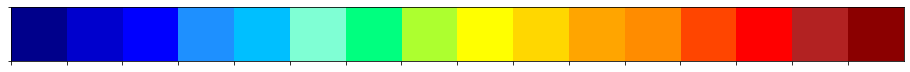

In [5]:
sns.palplot(sns.color_palette(ccc,16)) 

In [6]:
def convert_to_positive(img1,replacer=1e-10):
    img1[img1<=0]=replacer
    return img1

In [7]:
#boss0042

In [8]:
def Scaleimgconverter_nb_0042_1(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-0.0001,vmax=0.001)
    #norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm

def Scaleimgconverter_bw_0042_1(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0.03,vmax=0.05)
    return norm

def Scaleimgconverter_sb_0042_1(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-18,vmax=-15.3)
    return norm

In [9]:
kernel0042=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=7,y_size=7)
kernel_sb0042=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=11,y_size=11)

In [12]:
h_alpha_fits_nb_0042_1=fits.open('0042-1_nb.fits')
w_nb_0042_1 = WCS('0042-1_nb.fits')
data_nb_0042_1,header_nb_0042_1=fits.getdata('0042-1_nb.fits',header=True)
smoothed_img_nb_0042_1=convolve(data_nb_0042_1,kernel0042)

In [13]:
h_alpha_fits_bw_0042_1=fits.open('0042-1_bw.fits')
w_bw_0042_1 = WCS('0042-1_bw.fits')
data_bw_0042_1,header_bw_0042_1=fits.getdata('0042-1_bw.fits',header=True)
smoothed_img_bw_0042_1=convolve(data_bw_0042_1,kernel0042)

In [14]:
data_nb_p_0042_1=convert_to_positive(data_nb_0042_1)
data_bw_p_0042_1=convert_to_positive(data_bw_0042_1)

data_nb_seeing_0042_1=np.zeros(shape=(25,25))
data_bw_seeing_0042_1=np.zeros(shape=(25,25))

for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_nb_p_0042_1[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_nb_seeing_0042_1[k][l]=sum_cube
        sum_cube=0
        
for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_bw_p_0042_1[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_bw_seeing_0042_1[k][l]=sum_cube
        sum_cube=0

smoothed_img_nb_sb_0042_1=convolve(data_nb_0042_1,kernel_sb0042)
smoothed_img_bw_sb_0042_1=convolve(data_bw_0042_1,kernel_sb0042)

In [15]:
def count_to_lya_sb_0042(img_bw,img_nb,lamda_bw=4135,delta_lamda_bw=1278,lamda_nb=4030,delta_lamda_nb=45,replacer=1e-10):
    
    mag_bw=-2.5*np.log10(img_bw)+26.354
    mag_nb=-2.5*np.log10(img_nb)+22.833
    
    flux_per_frequency_bw=10**(-(mag_bw+48.6)/2.5)
    flux_per_frequency_nb=10**(-(mag_nb+48.6)/2.5)
    
    flux_per_wavelength_bw=flux_per_frequency_bw*const.c.to(u.AA/u.second).value/(lamda_bw**2)
    flux_per_wavelength_nb=flux_per_frequency_nb*const.c.to(u.AA/u.second).value/(lamda_nb**2)
    
    flux_bw=flux_per_wavelength_bw*delta_lamda_bw*u.erg/(u.second*(u.cm**2))
    flux_nb=flux_per_wavelength_nb*delta_lamda_nb*u.erg/(u.second*(u.cm**2))
    
    flux_per_wavelength_cont=(flux_bw-flux_nb)/(delta_lamda_bw-delta_lamda_nb)
    flux_lya=flux_nb-flux_per_wavelength_cont*delta_lamda_nb
    sur_bri_lya=flux_lya/0.25/0.25
    
    return sur_bri_lya.value

In [16]:
sur_bri_lya_0042_1=count_to_lya_sb_0042(smoothed_img_bw_sb_0042_1,smoothed_img_nb_sb_0042_1)
for i in range(len(sur_bri_lya_0042_1)):
    for j in range(len(sur_bri_lya_0042_1[1])):
        if sur_bri_lya_0042_1[i][j]<=0:
            sur_bri_lya_0042_1[i][j]=1e-100 
        sur_bri_lya_0042_1[i][j]=math.log(sur_bri_lya_0042_1[i][j],10)

In [17]:
def show_nebula_0042_1(img1,img2,img3):
    fig = plt.figure(figsize=(14,14))

    ax1 = fig.add_subplot(131)
    norm1 = Scaleimgconverter_bw_0042_1(img1)
    ax1.imshow(img1,norm=norm1,cmap=plt.cm.gray_r)
    ax1.invert_yaxis()
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.text(1, 95, 'BOSS0042-1',fontsize=14, color = "blue")
    ax1.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax1.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax1.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax1.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax1.text(6, 3, 'E',fontsize=14, color = "blue")
    ax1.text(23, 20, 'N',fontsize=14, color = "blue")

    
    ax2 = fig.add_subplot(132)
    norm2 = Scaleimgconverter_nb_0042_1(img2)
    ax2.imshow(img2,norm=norm2,cmap=plt.cm.gray_r)
    ax2.invert_yaxis()
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax2.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax2.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax2.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax2.text(6, 3, 'E',fontsize=14, color = "blue")
    ax2.text(23, 20, 'N',fontsize=14, color = "blue")
    #ax2.set_title('$\mathregular{NB403}$',fontsize=16)
    
    ax3 = fig.add_subplot(133)
    norm3=Scaleimgconverter_sb_0042_1(img3)
    xx, yy = np.meshgrid(np.arange(0,len(img3[0])), np.arange(0, len(img3)))
    axzz=ax3.imshow(img3,norm=norm3,cmap=clrmap)
    #cset = ax3.contour(xx, yy, img3, [5e-18])
    #ax3.clabel(cset, inline=0, fontsize=0)
    ax3.invert_yaxis()
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    
    #cb=plt.colorbar(axzz)
    
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0, hspace=None)
    
    fig.subplots_adjust(right=0.9)
    
    l = 0.93
    b = 0.373
    w = 0.015
    h = 0.24
    
    rect = [l,b,w,h] 
    cbar_ax = fig.add_axes(rect) 
    cb = plt.colorbar(axzz, cax=cbar_ax)
    cb.set_ticks([-19,-18,-17,-16])
    #cb.set_ticks([5e-18])
    cb.set_label('$\mathregular{lg(surface brightness)}\quad$[$\mathregular{erg\quad s^{-1} cm^{-2} arcsec^{-2}}$]')
    
    #ax4 = fig.add_subplot(144)
    #plt.rcParams['xtick.direction'] = 'in'
    #plt.rcParams['ytick.direction'] = 'in'
    #ax4.scatter(listlabels, calculate_radial_profile('0042-1_nb.fits', 'mean_value'), color = 'black', edgecolors='black', marker='o', s=35)
    #ax4.set_xlabel('radii(arcsec)',fontdict={'weight': 'normal', 'size': 13})
    #ax4.set_ylabel('$\mathregular{count/pixel^{2}}$',fontdict={'weight': 'normal', 'size': 13})

    

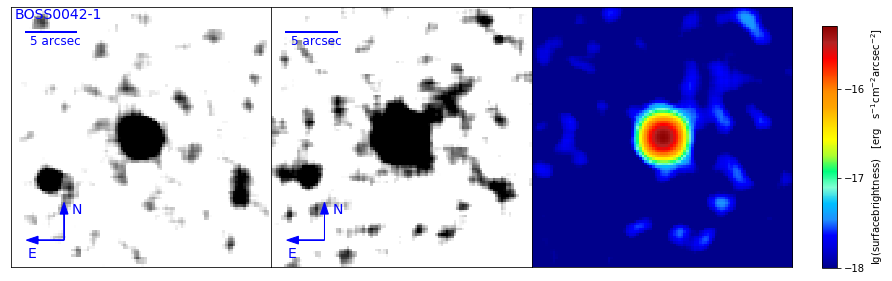

In [18]:
show_nebula_0042_1(smoothed_img_bw_0042_1,smoothed_img_nb_0042_1,sur_bri_lya_0042_1)

In [19]:
#boss0112

In [20]:
def Scaleimgconverter_nb_0112_1(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0.0025,vmax=0.0045)
    #norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm

def Scaleimgconverter_bw_0112_1(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-0.16,vmax=-0.13)
    return norm

def Scaleimgconverter_sb_0112_1(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-18,vmax=-15.3)
    return norm

In [21]:
kernel0112=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=7,y_size=7)
kernel_sb0112=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=11,y_size=11)

In [22]:
h_alpha_fits_nb_0112_1=fits.open('BOSS0112-1_nb.fits')
w_nb_0112_1 = WCS('BOSS0112-1_nb.fits')
data_nb_0112_1,header_nb_0112_1=fits.getdata('BOSS0112-1_nb.fits',header=True)
smoothed_img_nb_0112_1=convolve(data_nb_0112_1,kernel0112)

In [23]:
h_alpha_fits_bw_0112_1=fits.open('BOSS0112-1_bw.fits')
w_bw_0112_1 = WCS('BOSS0112-1_bw.fits')
data_bw_0112_1,header_bw_0112_1=fits.getdata('BOSS0112-1_bw.fits',header=True)
smoothed_img_bw_0112_1=convolve(data_bw_0112_1,kernel0112)

In [24]:
data_nb_p_0112_1=convert_to_positive(data_nb_0112_1)
data_bw_p_0112_1=convert_to_positive(data_bw_0112_1)

data_nb_seeing_0112_1=np.zeros(shape=(25,25))
data_bw_seeing_0112_1=np.zeros(shape=(25,25))

for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_nb_p_0112_1[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_nb_seeing_0112_1[k][l]=sum_cube
        sum_cube=0
        
for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_bw_p_0112_1[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_bw_seeing_0112_1[k][l]=sum_cube
        sum_cube=0

smoothed_img_nb_sb_0112_1=convolve(data_nb_0112_1,kernel_sb0112)
smoothed_img_bw_sb_0112_1=convolve(data_bw_0112_1,kernel_sb0112)    
    


In [25]:
def count_to_lya_sb_0112(img_bw,img_nb,lamda_bw=4135,delta_lamda_bw=1278,lamda_nb=4030,delta_lamda_nb=45,replacer=1e-10):
    
    mag_bw=-2.5*np.log10(img_bw)+26.358
    mag_nb=-2.5*np.log10(img_nb)+22.995
    
    flux_per_frequency_bw=10**(-(mag_bw+48.6)/2.5)
    flux_per_frequency_nb=10**(-(mag_nb+48.6)/2.5)
    
    flux_per_wavelength_bw=flux_per_frequency_bw*const.c.to(u.AA/u.second).value/(lamda_bw**2)
    flux_per_wavelength_nb=flux_per_frequency_nb*const.c.to(u.AA/u.second).value/(lamda_nb**2)
    
    flux_bw=flux_per_wavelength_bw*delta_lamda_bw*u.erg/(u.second*(u.cm**2))
    flux_nb=flux_per_wavelength_nb*delta_lamda_nb*u.erg/(u.second*(u.cm**2))
    
    flux_per_wavelength_cont=(flux_bw-flux_nb)/(delta_lamda_bw-delta_lamda_nb)
    flux_lya=flux_nb-flux_per_wavelength_cont*delta_lamda_nb
    sur_bri_lya=flux_lya/0.25/0.25
    
    return sur_bri_lya.value

In [26]:
sur_bri_lya_0112_1=count_to_lya_sb_0112(smoothed_img_bw_sb_0112_1,smoothed_img_nb_sb_0112_1)
for i in range(len(sur_bri_lya_0112_1)):
    for j in range(len(sur_bri_lya_0112_1[1])):
        if sur_bri_lya_0112_1[i][j]<=0:
            sur_bri_lya_0112_1[i][j]=1e-100 
        sur_bri_lya_0112_1[i][j]=math.log(sur_bri_lya_0112_1[i][j],10)
        

In [27]:
def show_nebula_0112_1(img1,img2,img3):
    fig = plt.figure(figsize=(14,14))

    ax1 = fig.add_subplot(131)
    norm1 = Scaleimgconverter_bw_0112_1(img1)
    ax1.imshow(img1,norm=norm1,cmap=plt.cm.gray_r)
    ax1.invert_yaxis()
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.text(1, 95, 'BOSS0112-1',fontsize=14, color = "blue")
    ax1.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax1.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax1.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax1.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax1.text(6, 3, 'E',fontsize=14, color = "blue")
    ax1.text(23, 20, 'N',fontsize=14, color = "blue")

    
    ax2 = fig.add_subplot(132)
    norm2 = Scaleimgconverter_nb_0112_1(img2)
    ax2.imshow(img2,norm=norm2,cmap=plt.cm.gray_r)
    ax2.invert_yaxis()
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax2.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax2.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax2.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax2.text(6, 3, 'E',fontsize=14, color = "blue")
    ax2.text(23, 20, 'N',fontsize=14, color = "blue")
    #ax2.set_title('$\mathregular{NB403}$',fontsize=16)
    
    ax3 = fig.add_subplot(133)
    norm3=Scaleimgconverter_sb_0112_1(img3)
    xx, yy = np.meshgrid(np.arange(0,len(img3[0])), np.arange(0, len(img3)))
    axzz=ax3.imshow(img3,norm=norm3,cmap=clrmap)
    #cset = ax3.contour(xx, yy, img3, [5e-18])
    #ax3.clabel(cset, inline=0, fontsize=0)
    ax3.invert_yaxis()
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    
    #cb=plt.colorbar(axzz)
    
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0, hspace=None)
    
    fig.subplots_adjust(right=0.9)
    
    l = 0.93
    b = 0.373
    w = 0.015
    h = 0.24
    
    rect = [l,b,w,h] 
    cbar_ax = fig.add_axes(rect) 
    cb = plt.colorbar(axzz, cax=cbar_ax)
    cb.set_ticks([-19,-18,-17,-16])
    #cb.semilog()
    cb.set_label('lg(surface brightness)[$\mathregular{erg\quad s^{-1} cm^{-2} arcsec^{-2}}$]') 


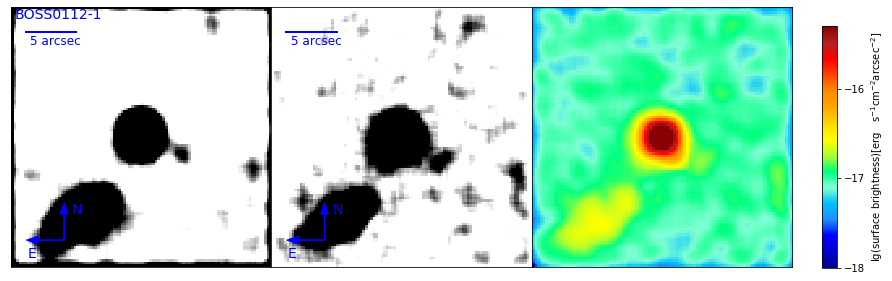

In [28]:
show_nebula_0112_1(smoothed_img_bw_0112_1,smoothed_img_nb_0112_1,sur_bri_lya_0112_1)

In [29]:
def Scaleimgconverter_nb_0112_2(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0.001,vmax=0.003)
    #norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm

def Scaleimgconverter_bw_0112_2(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-0.2,vmax=-0.17)
    return norm

def Scaleimgconverter_sb_0112_2(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-18,vmax=-15.3)
    return norm

In [30]:
kernel0112=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=7,y_size=7)
kernel_sb0112=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=11,y_size=11)

In [31]:
h_alpha_fits_nb_0112_2=fits.open('BOSS0112-2_nb.fits')
w_nb_0112_2 = WCS('BOSS0112-2_nb.fits')
data_nb_0112_2,header_nb_0112_2=fits.getdata('BOSS0112-2_nb.fits',header=True)
smoothed_img_nb_0112_2=convolve(data_nb_0112_2,kernel0112)

h_alpha_fits_bw_0112_2=fits.open('BOSS0112-2_bw.fits')
w_bw_0112_2 = WCS('BOSS0112-2_bw.fits')
data_bw_0112_2,header_bw_0112_2=fits.getdata('BOSS0112-2_bw.fits',header=True)
smoothed_img_bw_0112_2=convolve(data_bw_0112_2,kernel0112)

In [32]:
data_nb_p_0112_2=convert_to_positive(data_nb_0112_2)
data_bw_p_0112_2=convert_to_positive(data_bw_0112_2)

data_nb_seeing_0112_2=np.zeros(shape=(25,25))
data_bw_seeing_0112_2=np.zeros(shape=(25,25))

for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_nb_p_0112_2[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_nb_seeing_0112_2[k][l]=sum_cube
        sum_cube=0
        
for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_bw_p_0112_2[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_bw_seeing_0112_2[k][l]=sum_cube
        sum_cube=0

smoothed_img_nb_sb_0112_2=convolve(data_nb_0112_2,kernel_sb0112)
smoothed_img_bw_sb_0112_2=convolve(data_bw_0112_2,kernel_sb0112)    
    


In [33]:
def count_to_lya_sb_0112(img_bw,img_nb,lamda_bw=4135,delta_lamda_bw=1278,lamda_nb=4030,delta_lamda_nb=45,replacer=1e-10):
    
    mag_bw=-2.5*np.log10(img_bw)+26.358
    mag_nb=-2.5*np.log10(img_nb)+22.995
    
    flux_per_frequency_bw=10**(-(mag_bw+48.6)/2.5)
    flux_per_frequency_nb=10**(-(mag_nb+48.6)/2.5)
    
    flux_per_wavelength_bw=flux_per_frequency_bw*const.c.to(u.AA/u.second).value/(lamda_bw**2)
    flux_per_wavelength_nb=flux_per_frequency_nb*const.c.to(u.AA/u.second).value/(lamda_nb**2)
    
    flux_bw=flux_per_wavelength_bw*delta_lamda_bw*u.erg/(u.second*(u.cm**2))
    flux_nb=flux_per_wavelength_nb*delta_lamda_nb*u.erg/(u.second*(u.cm**2))
    
    flux_per_wavelength_cont=(flux_bw-flux_nb)/(delta_lamda_bw-delta_lamda_nb)
    flux_lya=flux_nb-flux_per_wavelength_cont*delta_lamda_nb
    sur_bri_lya=flux_lya/0.25/0.25
    
    return sur_bri_lya.value

In [34]:
sur_bri_lya_0112_2=count_to_lya_sb_0112(smoothed_img_bw_sb_0112_2,smoothed_img_nb_sb_0112_2)
for i in range(len(sur_bri_lya_0112_2)):
    for j in range(len(sur_bri_lya_0112_2[1])):
        if sur_bri_lya_0112_2[i][j]<=0:
            sur_bri_lya_0112_2[i][j]=1e-100
        sur_bri_lya_0112_2[i][j]=math.log(sur_bri_lya_0112_2[i][j],10)


In [35]:
def show_nebula_0112_2(img1,img2,img3):
    fig = plt.figure(figsize=(14,14))

    ax1 = fig.add_subplot(131)
    norm1 = Scaleimgconverter_bw_0112_2(img1)
    ax1.imshow(img1,norm=norm1,cmap=plt.cm.gray_r)
    ax1.invert_yaxis()
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.text(1, 95, 'BOSS0112-2',fontsize=14, color = "blue")
    ax1.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax1.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax1.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax1.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax1.text(6, 3, 'E',fontsize=14, color = "blue")
    ax1.text(23, 20, 'N',fontsize=14, color = "blue")

    
    ax2 = fig.add_subplot(132)
    norm2 = Scaleimgconverter_nb_0112_2(img2)
    ax2.imshow(img2,norm=norm2,cmap=plt.cm.gray_r)
    ax2.invert_yaxis()
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax2.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax2.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax2.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax2.text(6, 3, 'E',fontsize=14, color = "blue")
    ax2.text(23, 20, 'N',fontsize=14, color = "blue")
    #ax2.set_title('$\mathregular{NB403}$',fontsize=16)
    
    ax3 = fig.add_subplot(133)
    norm3=Scaleimgconverter_sb_0112_2(img3)
    xx, yy = np.meshgrid(np.arange(0,len(img3[0])), np.arange(0, len(img3)))
    axzz=ax3.imshow(img3,norm=norm3,cmap=clrmap)
    #cset = ax3.contourf(xx, yy, img3, locator=ticker.LogLocator(), colors='k')
    #cset = ax3.contour(xx, yy, img3, [5e-18,5e-17,5e-16], colors='k')
    #ax3.clabel(cset, inline=0, fontsize=0)
    ax3.invert_yaxis()
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    
    #cb=plt.colorbar(axzz)
    
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0, hspace=None)
    
    fig.subplots_adjust(right=0.9)
    
    l = 0.93
    b = 0.373
    w = 0.015
    h = 0.24
    
    rect = [l,b,w,h] 
    cbar_ax = fig.add_axes(rect) 
    cb = plt.colorbar(axzz, cax=cbar_ax)
    cb.set_ticks([-16,-17,-18])
    cb.set_label('lg(surface brightness)[$\mathregular{erg\quad s^{-1} cm^{-2} arcsec^{-2}}$]')


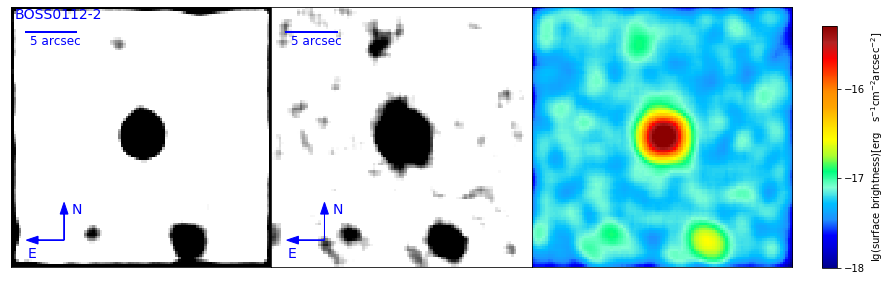

In [36]:
show_nebula_0112_2(smoothed_img_bw_0112_2,smoothed_img_nb_0112_2,sur_bri_lya_0112_2)

In [37]:
def Scaleimgconverter_nb_0112_3(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-0.002,vmax=0.003)
    #norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm

def Scaleimgconverter_bw_0112_3(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-0.25,vmax=0)
    return norm

def Scaleimgconverter_sb_0112_3(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-18,vmax=-15.3)
    return norm

In [38]:
kernel0112=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=7,y_size=7)
kernel_sb0112=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=11,y_size=11)

In [39]:
h_alpha_fits_nb_0112_3=fits.open('BOSS0112-3_nb.fits')
w_nb_0112_3 = WCS('BOSS0112-3_nb.fits')
data_nb_0112_3,header_nb_0112_3=fits.getdata('BOSS0112-3_nb.fits',header=True)
smoothed_img_nb_0112_3=convolve(data_nb_0112_3,kernel0112)

h_alpha_fits_bw_0112_3=fits.open('BOSS0112-3_bw.fits')
w_bw_0112_3 = WCS('BOSS0112-3_bw.fits')
data_bw_0112_3,header_bw_0112_3=fits.getdata('BOSS0112-3_bw.fits',header=True)
smoothed_img_bw_0112_3=convolve(data_bw_0112_3,kernel0112)

In [40]:
data_nb_p_0112_3=convert_to_positive(data_nb_0112_3)
data_bw_p_0112_3=convert_to_positive(data_bw_0112_3)

data_nb_seeing_0112_3=np.zeros(shape=(25,25))
data_bw_seeing_0112_3=np.zeros(shape=(25,25))


for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_nb_p_0112_3[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_nb_seeing_0112_3[k][l]=sum_cube
        sum_cube=0
        
for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_bw_p_0112_3[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_bw_seeing_0112_3[k][l]=sum_cube
        sum_cube=0

smoothed_img_nb_sb_0112_3=convolve(data_nb_0112_3,kernel_sb0112)
smoothed_img_bw_sb_0112_3=convolve(data_bw_0112_3,kernel_sb0112)    


In [41]:
def count_to_lya_sb_0112(img_bw,img_nb,lamda_bw=4135,delta_lamda_bw=1278,lamda_nb=4030,delta_lamda_nb=45,replacer=1e-10):
    
    mag_bw=-2.5*np.log10(img_bw)+26.358
    mag_nb=-2.5*np.log10(img_nb)+22.995
    
    flux_per_frequency_bw=10**(-(mag_bw+48.6)/2.5)
    flux_per_frequency_nb=10**(-(mag_nb+48.6)/2.5)
    
    flux_per_wavelength_bw=flux_per_frequency_bw*const.c.to(u.AA/u.second).value/(lamda_bw**2)
    flux_per_wavelength_nb=flux_per_frequency_nb*const.c.to(u.AA/u.second).value/(lamda_nb**2)
    
    flux_bw=flux_per_wavelength_bw*delta_lamda_bw*u.erg/(u.second*(u.cm**2))
    flux_nb=flux_per_wavelength_nb*delta_lamda_nb*u.erg/(u.second*(u.cm**2))
    
    flux_per_wavelength_cont=(flux_bw-flux_nb)/(delta_lamda_bw-delta_lamda_nb)
    flux_lya=flux_nb-flux_per_wavelength_cont*delta_lamda_nb
    sur_bri_lya=flux_lya/0.25/0.25
    
    return sur_bri_lya.value

In [42]:
sur_bri_lya_0112_3=count_to_lya_sb_0112(smoothed_img_bw_sb_0112_3,smoothed_img_nb_sb_0112_3)
for i in range(len(sur_bri_lya_0112_3)):
    for j in range(len(sur_bri_lya_0112_3[1])):
        if sur_bri_lya_0112_3[i][j]<0:
            sur_bri_lya_0112_3[i][j]=1e-100
        sur_bri_lya_0112_3[i][j]=math.log(sur_bri_lya_0112_3[i][j],10)

In [43]:
def show_nebula_0112_3(img1,img2,img3):
    fig = plt.figure(figsize=(14,14))

    ax1 = fig.add_subplot(131)
    norm1 = Scaleimgconverter_bw_0112_3(img1)
    ax1.imshow(img1,norm=norm1,cmap=plt.cm.gray_r)
    ax1.invert_yaxis()
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.text(1, 95, 'BOSS0112-3',fontsize=14, color = "blue")
    ax1.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax1.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax1.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax1.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax1.text(6, 3, 'E',fontsize=14, color = "blue")
    ax1.text(23, 20, 'N',fontsize=14, color = "blue")

    
    ax2 = fig.add_subplot(132)
    norm2 = Scaleimgconverter_nb_0112_3(img2)
    ax2.imshow(img2,norm=norm2,cmap=plt.cm.gray_r)
    ax2.invert_yaxis()
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax2.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax2.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax2.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax2.text(6, 3, 'E',fontsize=14, color = "blue")
    ax2.text(23, 20, 'N',fontsize=14, color = "blue")
    #ax2.set_title('$\mathregular{NB403}$',fontsize=16)
    
    ax3 = fig.add_subplot(133)
    norm3=Scaleimgconverter_sb_0112_3(img3)
    xx, yy = np.meshgrid(np.arange(0,len(img3[0])), np.arange(0, len(img3)))
    axzz=ax3.imshow(img3,norm=norm3,cmap=clrmap)
    #cset = ax3.contour(xx, yy, img3, [5e-18])
    #ax3.clabel(cset, inline=0, fontsize=0)
    ax3.invert_yaxis()
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    
    #cb=plt.colorbar(axzz)
    
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0, hspace=None)
    
    fig.subplots_adjust(right=0.9)
    
    l = 0.93
    b = 0.373
    w = 0.015
    h = 0.24
    
    rect = [l,b,w,h] 
    cbar_ax = fig.add_axes(rect) 
    cb = plt.colorbar(axzz, cax=cbar_ax)
    cb.set_ticks([-16,-17,-18])
    cb.set_label('lg(surface brightness)[$\mathregular{erg\quad s^{-1} cm^{-2} arcsec^{-2}}$]')


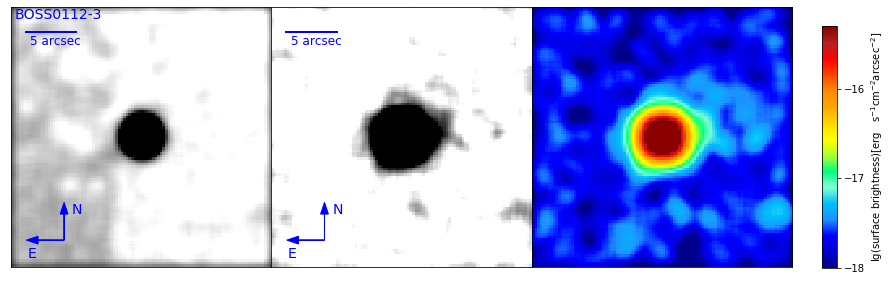

In [44]:
show_nebula_0112_3(smoothed_img_bw_0112_3,smoothed_img_nb_0112_3,sur_bri_lya_0112_3)

In [45]:
#boss0230

In [46]:
def Scaleimgconverter_nb_0230_1(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0.002,vmax=0.003)
    #norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm

def Scaleimgconverter_bw_0230_1(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0.045,vmax=0.06)
    return norm

def Scaleimgconverter_sb_0230_1(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-18,vmax=-15.3)
    return norm

In [47]:
kernel0230=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=7,y_size=7)
kernel_sb0230=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=11,y_size=11)

In [48]:
h_alpha_fits_nb_0230_1=fits.open('BOSS0230-1_nb.fits')
w_nb_0230_1 = WCS('BOSS0230-1_nb.fits')
data_nb_0230_1,header_nb_0230_1=fits.getdata('BOSS0230-1_nb.fits',header=True)
smoothed_img_nb_0230_1=convolve(data_nb_0230_1,kernel0230)

In [49]:
h_alpha_fits_bw_0230_1=fits.open('BOSS0230-1_bw.fits')
w_bw_0230_1 = WCS('BOSS0230-1_bw.fits')
data_bw_0230_1,header_bw_0230_1=fits.getdata('BOSS0230-1_bw.fits',header=True)
smoothed_img_bw_0230_1=convolve(data_bw_0230_1,kernel0230)

In [50]:
data_nb_p_0230_1=convert_to_positive(data_nb_0230_1)
data_bw_p_0230_1=convert_to_positive(data_bw_0230_1)

data_nb_seeing_0230_1=np.zeros(shape=(25,25))
data_bw_seeing_0230_1=np.zeros(shape=(25,25))


for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_nb_p_0230_1[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_nb_seeing_0230_1[k][l]=sum_cube
        sum_cube=0
        
for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_bw_p_0230_1[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_bw_seeing_0230_1[k][l]=sum_cube
        sum_cube=0

smoothed_img_nb_sb_0230_1=convolve(data_nb_0230_1,kernel_sb0230)
smoothed_img_bw_sb_0230_1=convolve(data_bw_0230_1,kernel_sb0230)  

In [51]:
def count_to_lya_sb_0230(img_bw,img_nb,lamda_bw=4135,delta_lamda_bw=1278,lamda_nb=4030,delta_lamda_nb=45,replacer=1e-10):
    
    mag_bw=-2.5*np.log10(img_bw)+26.234
    mag_nb=-2.5*np.log10(img_nb)+22.601
    
    flux_per_frequency_bw=10**(-(mag_bw+48.6)/2.5)
    flux_per_frequency_nb=10**(-(mag_nb+48.6)/2.5)
    
    flux_per_wavelength_bw=flux_per_frequency_bw*const.c.to(u.AA/u.second).value/(lamda_bw**2)
    flux_per_wavelength_nb=flux_per_frequency_nb*const.c.to(u.AA/u.second).value/(lamda_nb**2)
    
    flux_bw=flux_per_wavelength_bw*delta_lamda_bw*u.erg/(u.second*(u.cm**2))
    flux_nb=flux_per_wavelength_nb*delta_lamda_nb*u.erg/(u.second*(u.cm**2))
     
    flux_per_wavelength_cont=(flux_bw-flux_nb)/(delta_lamda_bw-delta_lamda_nb)
    flux_lya=flux_nb-flux_per_wavelength_cont*delta_lamda_nb
    sur_bri_lya=flux_lya/0.25/0.25
    
    return sur_bri_lya.value

In [52]:
sur_bri_lya_0230_1=count_to_lya_sb_0230(smoothed_img_bw_sb_0230_1,smoothed_img_nb_sb_0230_1)
for i in range(len(sur_bri_lya_0230_1)):
    for j in range(len(sur_bri_lya_0230_1[1])):
        if sur_bri_lya_0230_1[i][j]<0:
            sur_bri_lya_0230_1[i][j]=1e-100
        sur_bri_lya_0230_1[i][j]=math.log(sur_bri_lya_0230_1[i][j],10)

In [53]:
def show_nebula_0230_1(img1,img2,img3):
    fig = plt.figure(figsize=(14,14))

    ax1 = fig.add_subplot(131)
    norm1 = Scaleimgconverter_bw_0230_1(img1)
    ax1.imshow(img1,norm=norm1,cmap=plt.cm.gray_r)
    ax1.invert_yaxis()
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.text(1, 95, 'BOSS0230-1',fontsize=14, color = "blue")
    ax1.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax1.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax1.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax1.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax1.text(6, 3, 'E',fontsize=14, color = "blue")
    ax1.text(23, 20, 'N',fontsize=14, color = "blue")

    
    ax2 = fig.add_subplot(132)
    norm2 = Scaleimgconverter_nb_0230_1(img2)
    ax2.imshow(img2,norm=norm2,cmap=plt.cm.gray_r)
    ax2.invert_yaxis()
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax2.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax2.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax2.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax2.text(6, 3, 'E',fontsize=14, color = "blue")
    ax2.text(23, 20, 'N',fontsize=14, color = "blue")
    #ax2.set_title('$\mathregular{NB403}$',fontsize=16)
    
    ax3 = fig.add_subplot(133)
    norm3=Scaleimgconverter_sb_0230_1(img3)
    xx, yy = np.meshgrid(np.arange(0,len(img3[0])), np.arange(0, len(img3)))
    axzz=ax3.imshow(img3,norm=norm3,cmap=clrmap)
    #cset = ax3.contour(xx, yy, img3, [5e-18])
    #ax3.clabel(cset, inline=0, fontsize=0)
    ax3.invert_yaxis()
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    
    #cb=plt.colorbar(axzz)
    
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0, hspace=None)
    
    fig.subplots_adjust(right=0.9)
    
    l = 0.93
    b = 0.373
    w = 0.015
    h = 0.24
    
    rect = [l,b,w,h] 
    cbar_ax = fig.add_axes(rect) 
    cb = plt.colorbar(axzz, cax=cbar_ax)
    cb.set_ticks([-16,-17,-18])
    cb.set_label('lg(surface brightness)[$\mathregular{erg\quad s^{-1} cm^{-2} arcsec^{-2}}$]')


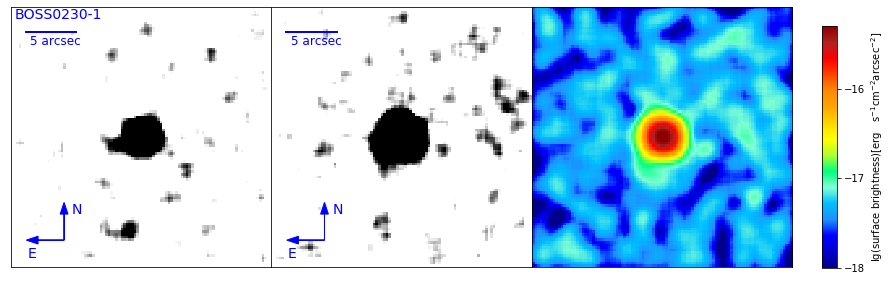

In [54]:
show_nebula_0230_1(smoothed_img_bw_0230_1,smoothed_img_nb_0230_1,sur_bri_lya_0230_1)

In [55]:
def Scaleimgconverter_nb_0230_2(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0.001,vmax=0.003)
    #norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm

def Scaleimgconverter_bw_0230_2(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0.01,vmax=0.06)
    return norm

def Scaleimgconverter_sb_0230_2(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-18,vmax=-15.3)
    return norm

In [56]:
kernel0230=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=7,y_size=7)
kernel_sb0230=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=11,y_size=11)

In [57]:
h_alpha_fits_nb_0230_2=fits.open('BOSS0230-2_nb.fits')
w_nb_0230_2 = WCS('BOSS0230-2_nb.fits')
data_nb_0230_2,header_nb_0230_2=fits.getdata('BOSS0230-2_nb.fits',header=True)
smoothed_img_nb_0230_2=convolve(data_nb_0230_2,kernel0230)

In [58]:
h_alpha_fits_bw_0230_2=fits.open('BOSS0230-2_bw.fits')
w_bw_0230_2 = WCS('BOSS0230-2_bw.fits')
data_bw_0230_2,header_bw_0230_2=fits.getdata('BOSS0230-2_bw.fits',header=True)
smoothed_img_bw_0230_2=convolve(data_bw_0230_2,kernel0230)

In [59]:
data_nb_p_0230_2=convert_to_positive(data_nb_0230_2)
data_bw_p_0230_2=convert_to_positive(data_bw_0230_2)

data_nb_seeing_0230_2=np.zeros(shape=(25,25))
data_bw_seeing_0230_2=np.zeros(shape=(25,25))


for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_nb_p_0230_2[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_nb_seeing_0230_2[k][l]=sum_cube
        sum_cube=0
        
for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_bw_p_0230_2[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_bw_seeing_0230_2[k][l]=sum_cube
        sum_cube=0

smoothed_img_nb_sb_0230_2=convolve(data_nb_0230_2,kernel_sb0230)
smoothed_img_bw_sb_0230_2=convolve(data_bw_0230_2,kernel_sb0230)  

In [60]:
def count_to_lya_sb_0230(img_bw,img_nb,lamda_bw=4135,delta_lamda_bw=1278,lamda_nb=4030,delta_lamda_nb=45,replacer=1e-10):
    
    mag_bw=-2.5*np.log10(img_bw)+26.234
    mag_nb=-2.5*np.log10(img_nb)+22.601
    
    flux_per_frequency_bw=10**(-(mag_bw+48.6)/2.5)
    flux_per_frequency_nb=10**(-(mag_nb+48.6)/2.5)
    
    flux_per_wavelength_bw=flux_per_frequency_bw*const.c.to(u.AA/u.second).value/(lamda_bw**2)
    flux_per_wavelength_nb=flux_per_frequency_nb*const.c.to(u.AA/u.second).value/(lamda_nb**2)
    
    flux_bw=flux_per_wavelength_bw*delta_lamda_bw*u.erg/(u.second*(u.cm**2))
    flux_nb=flux_per_wavelength_nb*delta_lamda_nb*u.erg/(u.second*(u.cm**2))
     
    flux_per_wavelength_cont=(flux_bw-flux_nb)/(delta_lamda_bw-delta_lamda_nb)
    flux_lya=flux_nb-flux_per_wavelength_cont*delta_lamda_nb
    sur_bri_lya=flux_lya/0.25/0.25
    
    return sur_bri_lya.value

In [61]:
sur_bri_lya_0230_2=count_to_lya_sb_0230(smoothed_img_bw_sb_0230_2,smoothed_img_nb_sb_0230_2)
for i in range(len(sur_bri_lya_0230_2)):
    for j in range(len(sur_bri_lya_0230_2[1])):
        if sur_bri_lya_0230_2[i][j]<0:
            sur_bri_lya_0230_2[i][j]=1e-100
        sur_bri_lya_0230_2[i][j]=math.log(sur_bri_lya_0230_2[i][j],10)

In [62]:
def show_nebula_0230_2(img1,img2,img3):
    fig = plt.figure(figsize=(14,14))

    ax1 = fig.add_subplot(131)
    norm1 = Scaleimgconverter_bw_0230_2(img1)
    ax1.imshow(img1,norm=norm1,cmap=plt.cm.gray_r)
    ax1.invert_yaxis()
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.text(1, 95, 'BOSS0230-2',fontsize=14, color = "blue")
    ax1.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax1.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax1.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax1.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax1.text(6, 3, 'E',fontsize=14, color = "blue")
    ax1.text(23, 20, 'N',fontsize=14, color = "blue")

    
    ax2 = fig.add_subplot(132)
    norm2 = Scaleimgconverter_nb_0230_2(img2)
    ax2.imshow(img2,norm=norm2,cmap=plt.cm.gray_r)
    ax2.invert_yaxis()
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax2.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax2.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax2.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax2.text(6, 3, 'E',fontsize=14, color = "blue")
    ax2.text(23, 20, 'N',fontsize=14, color = "blue")
    #ax2.set_title('$\mathregular{NB403}$',fontsize=16)
    
    ax3 = fig.add_subplot(133)
    norm3=Scaleimgconverter_sb_0230_2(img3)
    xx, yy = np.meshgrid(np.arange(0,len(img3[0])), np.arange(0, len(img3)))
    axzz=ax3.imshow(img3,norm=norm3,cmap=clrmap)
    #cset = ax3.contour(xx, yy, img3, [5e-18], colors='k')
    #ax3.clabel(cset, inline=0, fontsize=0)
    ax3.invert_yaxis()
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    
    #cb=plt.colorbar(axzz)
    
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0, hspace=None)
    
    fig.subplots_adjust(right=0.9)
    
    l = 0.93
    b = 0.373
    w = 0.015
    h = 0.24
    
    rect = [l,b,w,h] 
    cbar_ax = fig.add_axes(rect) 
    cb = plt.colorbar(axzz, cax=cbar_ax)
    cb.set_ticks([-18,-17,-16])
    cb.set_label('lg(surface brightness)[$\mathregular{erg\quad s^{-1} cm^{-2} arcsec^{-2}}$]')


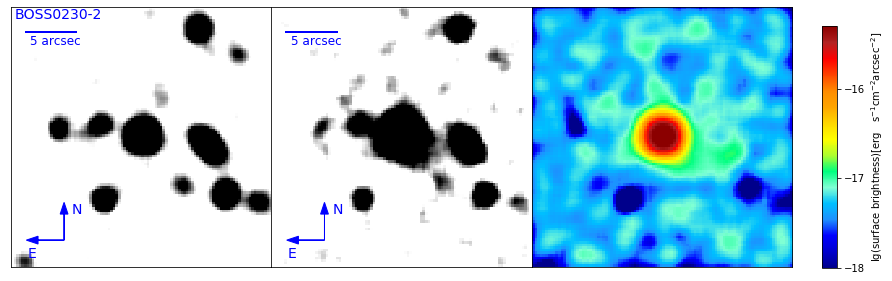

In [63]:
show_nebula_0230_2(smoothed_img_bw_0230_2,smoothed_img_nb_0230_2,sur_bri_lya_0230_2)

In [64]:
#boss1412

In [65]:
def Scaleimgconverter_nb_1412_1(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0,vmax=0.002)
    #norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm

def Scaleimgconverter_bw_1412_1(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0.01,vmax=0.05)
    return norm

def Scaleimgconverter_sb_1412_1(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-18,vmax=-15.3)
    return norm

In [66]:
kernel1412=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=7,y_size=7)
kernel_sb1412=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=11,y_size=11)

In [67]:
h_alpha_fits_nb_1412_1=fits.open('1412-1_nb.fits')
w_nb_1412_1 = WCS('1412-1_nb.fits')
data_nb_1412_1,header_nb_1412_1=fits.getdata('1412-1_nb.fits',header=True)
smoothed_img_nb_1412_1=convolve(data_nb_1412_1,kernel1412)

In [68]:
h_alpha_fits_bw_1412_1=fits.open('1412-1_bw.fits')
w_bw_1412_1 = WCS('1412-1_bw.fits')
data_bw_1412_1,header_bw_1412_1=fits.getdata('1412-1_bw.fits',header=True)
smoothed_img_bw_1412_1=convolve(data_bw_1412_1,kernel1412)

In [69]:
data_nb_p_1412_1=convert_to_positive(data_nb_1412_1)
data_bw_p_1412_1=convert_to_positive(data_bw_1412_1)

data_nb_seeing_1412_1=np.zeros(shape=(25,25))
data_bw_seeing_1412_1=np.zeros(shape=(25,25))


for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_nb_p_1412_1[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_nb_seeing_1412_1[k][l]=sum_cube
        sum_cube=0
        
for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_bw_p_1412_1[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_bw_seeing_1412_1[k][l]=sum_cube
        sum_cube=0

smoothed_img_nb_sb_1412_1=convolve(data_nb_1412_1,kernel_sb1412)
smoothed_img_bw_sb_1412_1=convolve(data_bw_1412_1,kernel_sb1412)  


In [70]:
def count_to_lya_sb_1412(img_bw,img_nb,lamda_bw=4135,delta_lamda_bw=1278,lamda_nb=4030,delta_lamda_nb=45,replacer=1e-10):
    
    mag_bw=-2.5*np.log10(img_bw)+26.354
    mag_nb=-2.5*np.log10(img_nb)+22.833
    
    flux_per_frequency_bw=10**(-(mag_bw+48.6)/2.5)
    flux_per_frequency_nb=10**(-(mag_nb+48.6)/2.5)
    
    flux_per_wavelength_bw=flux_per_frequency_bw*const.c.to(u.AA/u.second).value/(lamda_bw**2)
    flux_per_wavelength_nb=flux_per_frequency_nb*const.c.to(u.AA/u.second).value/(lamda_nb**2)
    
    flux_bw=flux_per_wavelength_bw*delta_lamda_bw*u.erg/(u.second*(u.cm**2))
    flux_nb=flux_per_wavelength_nb*delta_lamda_nb*u.erg/(u.second*(u.cm**2))
     
    flux_per_wavelength_cont=(flux_bw-flux_nb)/(delta_lamda_bw-delta_lamda_nb)
    flux_lya=flux_nb-flux_per_wavelength_cont*delta_lamda_nb
    sur_bri_lya=flux_lya/0.25/0.25
    
    return sur_bri_lya.value

In [71]:
sur_bri_lya_1412_1=count_to_lya_sb_1412(smoothed_img_bw_sb_1412_1,smoothed_img_nb_sb_1412_1)
for i in range(len(sur_bri_lya_1412_1)):
    for j in range(len(sur_bri_lya_1412_1[1])):
        if sur_bri_lya_1412_1[i][j]<0:
            sur_bri_lya_1412_1[i][j]=1e-100
        sur_bri_lya_1412_1[i][j]=math.log(sur_bri_lya_1412_1[i][j],10)

In [72]:
def show_nebula_1412_1(img1,img2,img3):
    fig = plt.figure(figsize=(14,14))

    ax1 = fig.add_subplot(131)
    norm1 = Scaleimgconverter_bw_1412_1(img1)
    ax1.imshow(img1,norm=norm1,cmap=plt.cm.gray_r)
    ax1.invert_yaxis()
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.text(1, 95, 'BOSS1412-1',fontsize=14, color = "blue")
    ax1.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax1.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax1.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax1.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax1.text(6, 3, 'E',fontsize=14, color = "blue")
    ax1.text(23, 20, 'N',fontsize=14, color = "blue")

    
    ax2 = fig.add_subplot(132)
    norm2 = Scaleimgconverter_nb_1412_1(img2)
    ax2.imshow(img2,norm=norm2,cmap=plt.cm.gray_r)
    ax2.invert_yaxis()
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax2.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax2.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax2.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax2.text(6, 3, 'E',fontsize=14, color = "blue")
    ax2.text(23, 20, 'N',fontsize=14, color = "blue")
    #ax2.set_title('$\mathregular{NB403}$',fontsize=16)
    
    ax3 = fig.add_subplot(133)
    norm3=Scaleimgconverter_sb_1412_1(img3)
    xx, yy = np.meshgrid(np.arange(0,len(img3[0])), np.arange(0, len(img3)))
    axzz=ax3.imshow(img3,norm=norm3,cmap=clrmap)
    #cset = ax3.contour(xx, yy, img3, [5e-18], colors='k')
    #ax3.clabel(cset, inline=0, fontsize=0)
    ax3.invert_yaxis()
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    
    #cb=plt.colorbar(axzz)
    
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0, hspace=None)
    
    fig.subplots_adjust(right=0.9)
    
    l = 0.93
    b = 0.373
    w = 0.015
    h = 0.24
    
    rect = [l,b,w,h] 
    cbar_ax = fig.add_axes(rect) 
    cb = plt.colorbar(axzz, cax=cbar_ax)
    cb.set_ticks([-16,-17,-18])
    cb.set_label('lg(surface brightness)[$\mathregular{erg\quad s^{-1} cm^{-2} arcsec^{-2}}$]')


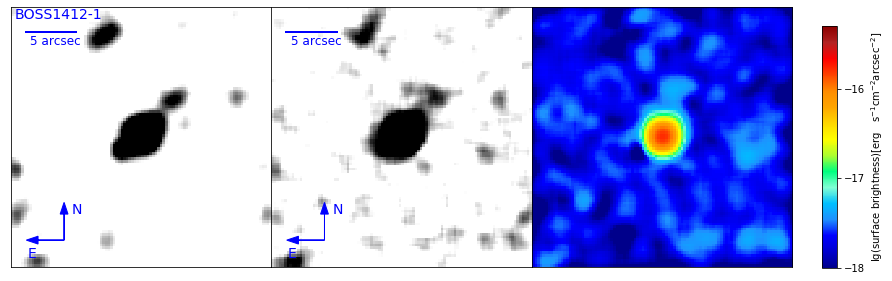

In [73]:
show_nebula_1412_1(smoothed_img_bw_1412_1,smoothed_img_nb_1412_1,sur_bri_lya_1412_1)

In [74]:
def Scaleimgconverter_nb_1412_2(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0,vmax=0.002)
    #norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm

def Scaleimgconverter_bw_1412_2(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0.01,vmax=0.1)
    return norm

def Scaleimgconverter_sb_1412_2(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-18,vmax=-15.3)
    return norm

In [75]:
kernel1412=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=7,y_size=7)
kernel_sb1412=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=11,y_size=11)

In [76]:
h_alpha_fits_nb_1412_2=fits.open('1412-2_nb.fits')
w_nb_1412_2 = WCS('1412-2_nb.fits')
data_nb_1412_2,header_nb_1412_2=fits.getdata('1412-2_nb.fits',header=True)
smoothed_img_nb_1412_2=convolve(data_nb_1412_2,kernel1412)

In [77]:
h_alpha_fits_bw_1412_2=fits.open('1412-2_bw.fits')
w_bw_1412_2 = WCS('1412-2_bw.fits')
data_bw_1412_2,header_bw_1412_2=fits.getdata('1412-2_bw.fits',header=True)
smoothed_img_bw_1412_2=convolve(data_bw_1412_2,kernel1412)

In [78]:
data_nb_p_1412_2=convert_to_positive(data_nb_1412_2)
data_bw_p_1412_2=convert_to_positive(data_bw_1412_2)

data_nb_seeing_1412_2=np.zeros(shape=(25,25))
data_bw_seeing_1412_2=np.zeros(shape=(25,25))


for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_nb_p_1412_2[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_nb_seeing_1412_2[k][l]=sum_cube
        sum_cube=0
        
for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_bw_p_1412_2[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_bw_seeing_1412_2[k][l]=sum_cube
        sum_cube=0

smoothed_img_nb_sb_1412_2=convolve(data_nb_1412_2,kernel_sb1412)
smoothed_img_bw_sb_1412_2=convolve(data_bw_1412_2,kernel_sb1412)   


In [79]:
def count_to_lya_sb_1412(img_bw,img_nb,lamda_bw=4135,delta_lamda_bw=1278,lamda_nb=4030,delta_lamda_nb=45,replacer=1e-10):
    
    mag_bw=-2.5*np.log10(img_bw)+26.354
    mag_nb=-2.5*np.log10(img_nb)+22.833
    
    flux_per_frequency_bw=10**(-(mag_bw+48.6)/2.5)
    flux_per_frequency_nb=10**(-(mag_nb+48.6)/2.5)
    
    flux_per_wavelength_bw=flux_per_frequency_bw*const.c.to(u.AA/u.second).value/(lamda_bw**2)
    flux_per_wavelength_nb=flux_per_frequency_nb*const.c.to(u.AA/u.second).value/(lamda_nb**2)
    
    flux_bw=flux_per_wavelength_bw*delta_lamda_bw*u.erg/(u.second*(u.cm**2))
    flux_nb=flux_per_wavelength_nb*delta_lamda_nb*u.erg/(u.second*(u.cm**2))
     
    flux_per_wavelength_cont=(flux_bw-flux_nb)/(delta_lamda_bw-delta_lamda_nb)
    flux_lya=flux_nb-flux_per_wavelength_cont*delta_lamda_nb
    sur_bri_lya=flux_lya/0.25/0.25
    
    return sur_bri_lya.value

In [80]:
sur_bri_lya_1412_2=count_to_lya_sb_1412(smoothed_img_bw_sb_1412_2,smoothed_img_nb_sb_1412_2)
for i in range(len(sur_bri_lya_1412_2)):
    for j in range(len(sur_bri_lya_1412_2[1])):
        if sur_bri_lya_1412_2[i][j]<0:
            sur_bri_lya_1412_2[i][j]=1e-100
        sur_bri_lya_1412_2[i][j]=math.log(sur_bri_lya_1412_2[i][j],10)

In [81]:
def show_nebula_1412_2(img1,img2,img3):
    fig = plt.figure(figsize=(14,14))

    ax1 = fig.add_subplot(131)
    norm1 = Scaleimgconverter_bw_1412_2(img1)
    ax1.imshow(img1,norm=norm1,cmap=plt.cm.gray_r)
    ax1.invert_yaxis()
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.text(1, 95, 'BOSS1412-2',fontsize=14, color = "blue")
    ax1.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax1.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax1.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax1.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax1.text(6, 3, 'E',fontsize=14, color = "blue")
    ax1.text(23, 20, 'N',fontsize=14, color = "blue")

    
    ax2 = fig.add_subplot(132)
    norm2 = Scaleimgconverter_nb_1412_2(img2)
    ax2.imshow(img2,norm=norm2,cmap=plt.cm.gray_r)
    ax2.invert_yaxis()
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax2.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax2.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax2.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax2.text(6, 3, 'E',fontsize=14, color = "blue")
    ax2.text(23, 20, 'N',fontsize=14, color = "blue")
    #ax2.set_title('$\mathregular{NB403}$',fontsize=16)
    
    ax3 = fig.add_subplot(133)
    norm3=Scaleimgconverter_sb_1412_2(img3)
    xx, yy = np.meshgrid(np.arange(0,len(img3[0])), np.arange(0, len(img3)))
    axzz=ax3.imshow(img3,norm=norm3,cmap=clrmap)
    #cset = ax3.contour(xx, yy, img3, [5e-18], colors='k')
    #ax3.clabel(cset, inline=0, fontsize=0)
    ax3.invert_yaxis()
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    
    #cb=plt.colorbar(axzz)
    
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0, hspace=None)
    
    fig.subplots_adjust(right=0.9)
    
    l = 0.93
    b = 0.373
    w = 0.015
    h = 0.24
    
    rect = [l,b,w,h] 
    cbar_ax = fig.add_axes(rect) 
    cb = plt.colorbar(axzz, cax=cbar_ax)
    cb.set_ticks([-16,-17,-18])
    cb.set_label('lg(surface brightness)[$\mathregular{erg\quad s^{-1} cm^{-2} arcsec^{-2}}$]')


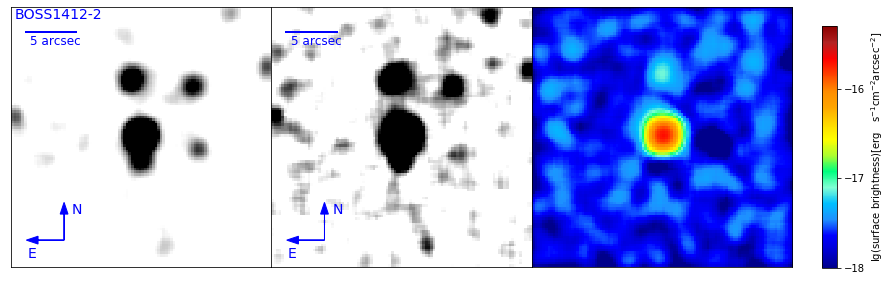

In [82]:
show_nebula_1412_2(smoothed_img_bw_1412_2,smoothed_img_nb_1412_2,sur_bri_lya_1412_2)

In [83]:
def Scaleimgconverter_nb_1412_3(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0.001,vmax=0.002)
    #norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm

def Scaleimgconverter_bw_1412_3(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0.04,vmax=0.07)
    return norm

def Scaleimgconverter_sb_1412_3(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-18,vmax=-15.3)
    return norm

In [84]:
kernel1412=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=7,y_size=7)
kernel_sb1412=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=11,y_size=11)

In [85]:
h_alpha_fits_nb_1412_3=fits.open('1412-3_nb.fits')
w_nb_1412_3 = WCS('1412-3_nb.fits')
data_nb_1412_3,header_nb_1412_3=fits.getdata('1412-3_nb.fits',header=True)
smoothed_img_nb_1412_3=convolve(data_nb_1412_3,kernel1412)

In [86]:
h_alpha_fits_bw_1412_3=fits.open('1412-3_bw.fits')
w_bw_1412_3 = WCS('1412-3_bw.fits')
data_bw_1412_3,header_bw_1412_3=fits.getdata('1412-3_bw.fits',header=True)
smoothed_img_bw_1412_3=convolve(data_bw_1412_3,kernel1412)

In [87]:
data_nb_p_1412_3=convert_to_positive(data_nb_1412_3)
data_bw_p_1412_3=convert_to_positive(data_bw_1412_3)

data_nb_seeing_1412_3=np.zeros(shape=(25,25))
data_bw_seeing_1412_3=np.zeros(shape=(25,25))


for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_nb_p_1412_3[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_nb_seeing_1412_3[k][l]=sum_cube
        sum_cube=0
        
for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_bw_p_1412_3[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_bw_seeing_1412_3[k][l]=sum_cube
        sum_cube=0

smoothed_img_nb_sb_1412_3=convolve(data_nb_1412_3,kernel_sb1412)
smoothed_img_bw_sb_1412_3=convolve(data_bw_1412_3,kernel_sb1412)   


In [88]:
def count_to_lya_sb_1412(img_bw,img_nb,lamda_bw=4135,delta_lamda_bw=1278,lamda_nb=4030,delta_lamda_nb=45,replacer=1e-10):
    
    mag_bw=-2.5*np.log10(img_bw)+26.354
    mag_nb=-2.5*np.log10(img_nb)+22.833
    
    flux_per_frequency_bw=10**(-(mag_bw+48.6)/2.5)
    flux_per_frequency_nb=10**(-(mag_nb+48.6)/2.5)
    
    flux_per_wavelength_bw=flux_per_frequency_bw*const.c.to(u.AA/u.second).value/(lamda_bw**2)
    flux_per_wavelength_nb=flux_per_frequency_nb*const.c.to(u.AA/u.second).value/(lamda_nb**2)
    
    flux_bw=flux_per_wavelength_bw*delta_lamda_bw*u.erg/(u.second*(u.cm**2))
    flux_nb=flux_per_wavelength_nb*delta_lamda_nb*u.erg/(u.second*(u.cm**2))
     
    flux_per_wavelength_cont=(flux_bw-flux_nb)/(delta_lamda_bw-delta_lamda_nb)
    flux_lya=flux_nb-flux_per_wavelength_cont*delta_lamda_nb
    sur_bri_lya=flux_lya/0.25/0.25
    
    return sur_bri_lya.value

In [89]:
sur_bri_lya_1412_3=count_to_lya_sb_1412(smoothed_img_bw_sb_1412_3,smoothed_img_nb_sb_1412_3)
for i in range(len(sur_bri_lya_1412_3)):
    for j in range(len(sur_bri_lya_1412_3[1])):
        if sur_bri_lya_1412_3[i][j]<0:
            sur_bri_lya_1412_3[i][j]=1e-100
        sur_bri_lya_1412_3[i][j]=math.log(sur_bri_lya_1412_3[i][j],10)

In [90]:
def show_nebula_1412_3(img1,img2,img3):
    fig = plt.figure(figsize=(14,14))

    ax1 = fig.add_subplot(131)
    norm1 = Scaleimgconverter_bw_1412_3(img1)
    ax1.imshow(img1,norm=norm1,cmap=plt.cm.gray_r)
    ax1.invert_yaxis()
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.text(1, 95, 'BOSS1412-3',fontsize=14, color = "blue")
    ax1.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax1.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax1.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax1.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax1.text(6, 3, 'E',fontsize=14, color = "blue")
    ax1.text(23, 20, 'N',fontsize=14, color = "blue")

    
    ax2 = fig.add_subplot(132)
    norm2 = Scaleimgconverter_nb_1412_3(img2)
    ax2.imshow(img2,norm=norm2,cmap=plt.cm.gray_r)
    ax2.invert_yaxis()
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax2.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax2.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax2.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax2.text(6, 3, 'E',fontsize=14, color = "blue")
    ax2.text(23, 20, 'N',fontsize=14, color = "blue")
    #ax2.set_title('$\mathregular{NB403}$',fontsize=16)
    
    ax3 = fig.add_subplot(133)
    norm3=Scaleimgconverter_sb_1412_3(img3)
    xx, yy = np.meshgrid(np.arange(0,len(img3[0])), np.arange(0, len(img3)))
    axzz=ax3.imshow(img3,norm=norm3,cmap=clrmap)
    #cset = ax3.contour(xx, yy, img3, [5e-18], colors='k')
    #ax3.clabel(cset, inline=0, fontsize=0)
    ax3.invert_yaxis()
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    
    #cb=plt.colorbar(axzz)
    
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0, hspace=None)
    
    fig.subplots_adjust(right=0.9)
    
    l = 0.93
    b = 0.373
    w = 0.015
    h = 0.24
    
    rect = [l,b,w,h] 
    cbar_ax = fig.add_axes(rect) 
    cb = plt.colorbar(axzz, cax=cbar_ax)
    cb.set_ticks([-18,-17,-16])
    cb.set_label('lg(surface brightness)[$\mathregular{erg\quad s^{-1} cm^{-2} arcsec^{-2}}$]')


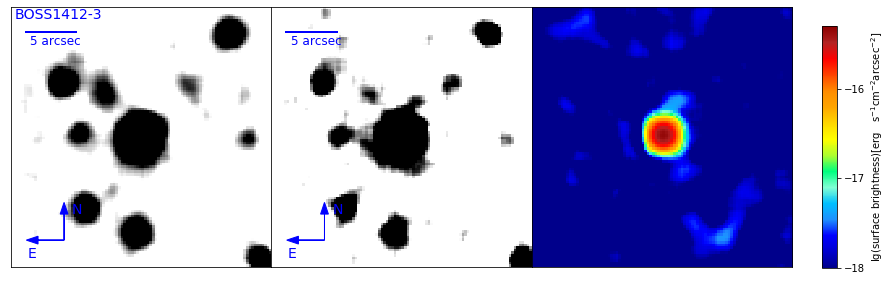

In [91]:
show_nebula_1412_3(smoothed_img_bw_1412_3,smoothed_img_nb_1412_3,sur_bri_lya_1412_3)

In [92]:
def Scaleimgconverter_nb_1412_4(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0.002,vmax=0.004)
    #norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm

def Scaleimgconverter_bw_1412_4(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0.03,vmax=0.05)
    return norm

def Scaleimgconverter_sb_1412_4(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-18,vmax=-15.3)
    return norm

In [93]:
kernel1412=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=7,y_size=7)
kernel_sb1412=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=11,y_size=11)

In [94]:
h_alpha_fits_nb_1412_4=fits.open('1412-4_nb.fits')
w_nb_1412_4 = WCS('1412-4_nb.fits')
data_nb_1412_4,header_nb_1412_4=fits.getdata('1412-4_nb.fits',header=True)
smoothed_img_nb_1412_4=convolve(data_nb_1412_4,kernel1412)

In [95]:
h_alpha_fits_bw_1412_4=fits.open('1412-4_bw.fits')
w_bw_1412_4 = WCS('1412-4_bw.fits')
data_bw_1412_4,header_bw_1412_4=fits.getdata('1412-4_bw.fits',header=True)
smoothed_img_bw_1412_4=convolve(data_bw_1412_4,kernel1412)

In [96]:
data_nb_p_1412_4=convert_to_positive(data_nb_1412_4)
data_bw_p_1412_4=convert_to_positive(data_bw_1412_4)

data_nb_seeing_1412_4=np.zeros(shape=(25,25))
data_bw_seeing_1412_4=np.zeros(shape=(25,25))


for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_nb_p_1412_4[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_nb_seeing_1412_4[k][l]=sum_cube
        sum_cube=0
        
for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_bw_p_1412_4[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_bw_seeing_1412_4[k][l]=sum_cube
        sum_cube=0

smoothed_img_nb_sb_1412_4=convolve(data_nb_1412_4,kernel_sb1412)
smoothed_img_bw_sb_1412_4=convolve(data_bw_1412_4,kernel_sb1412)   


In [97]:
def count_to_lya_sb_1412(img_bw,img_nb,lamda_bw=4135,delta_lamda_bw=1278,lamda_nb=4030,delta_lamda_nb=45,replacer=1e-10):
    
    mag_bw=-2.5*np.log10(img_bw)+26.354
    mag_nb=-2.5*np.log10(img_nb)+22.833
    
    flux_per_frequency_bw=10**(-(mag_bw+48.6)/2.5)
    flux_per_frequency_nb=10**(-(mag_nb+48.6)/2.5)
    
    flux_per_wavelength_bw=flux_per_frequency_bw*const.c.to(u.AA/u.second).value/(lamda_bw**2)
    flux_per_wavelength_nb=flux_per_frequency_nb*const.c.to(u.AA/u.second).value/(lamda_nb**2)
    
    flux_bw=flux_per_wavelength_bw*delta_lamda_bw*u.erg/(u.second*(u.cm**2))
    flux_nb=flux_per_wavelength_nb*delta_lamda_nb*u.erg/(u.second*(u.cm**2))
     
    flux_per_wavelength_cont=(flux_bw-flux_nb)/(delta_lamda_bw-delta_lamda_nb)
    flux_lya=flux_nb-flux_per_wavelength_cont*delta_lamda_nb
    sur_bri_lya=flux_lya/0.25/0.25
    
    return sur_bri_lya.value

In [98]:
sur_bri_lya_1412_4=count_to_lya_sb_1412(smoothed_img_bw_sb_1412_4,smoothed_img_nb_sb_1412_4)
for i in range(len(sur_bri_lya_1412_4)):
    for j in range(len(sur_bri_lya_1412_4[1])):
        if sur_bri_lya_1412_4[i][j]<0:
            sur_bri_lya_1412_4[i][j]=1e-100
        sur_bri_lya_1412_4[i][j]=math.log(sur_bri_lya_1412_4[i][j],10)

In [99]:
def show_nebula_1412_4(img1,img2,img3):
    fig = plt.figure(figsize=(14,14))

    ax1 = fig.add_subplot(131)
    norm1 = Scaleimgconverter_bw_1412_4(img1)
    ax1.imshow(img1,norm=norm1,cmap=plt.cm.gray_r)
    ax1.invert_yaxis()
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.text(1, 95, 'BOSS1412-4',fontsize=14, color = "blue")
    ax1.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax1.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax1.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax1.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax1.text(6, 3, 'E',fontsize=14, color = "blue")
    ax1.text(23, 20, 'N',fontsize=14, color = "blue")

    
    ax2 = fig.add_subplot(132)
    norm2 = Scaleimgconverter_nb_1412_4(img2)
    ax2.imshow(img2,norm=norm2,cmap=plt.cm.gray_r)
    ax2.invert_yaxis()
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax2.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax2.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax2.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax2.text(6, 3, 'E',fontsize=14, color = "blue")
    ax2.text(23, 20, 'N',fontsize=14, color = "blue")
    #ax2.set_title('$\mathregular{NB403}$',fontsize=16)
    
    ax3 = fig.add_subplot(133)
    norm3=Scaleimgconverter_sb_1412_4(img3)
    xx, yy = np.meshgrid(np.arange(0,len(img3[0])), np.arange(0, len(img3)))
    axzz=ax3.imshow(img3,norm=norm3,cmap=clrmap)
    #cset = ax3.contour(xx, yy, img3, [5e-18], colors='k')
    #ax3.clabel(cset, inline=0, fontsize=0)
    ax3.invert_yaxis()
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    
    #cb=plt.colorbar(axzz)
    
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0, hspace=None)
    
    fig.subplots_adjust(right=0.9)
    
    l = 0.93
    b = 0.373
    w = 0.015
    h = 0.24
    
    rect = [l,b,w,h] 
    cbar_ax = fig.add_axes(rect) 
    cb = plt.colorbar(axzz, cax=cbar_ax)
    cb.set_ticks([-18,-17,-16])
    cb.set_label('lg(surface brightness)[$\mathregular{erg\quad s^{-1} cm^{-2} arcsec^{-2}}$]')


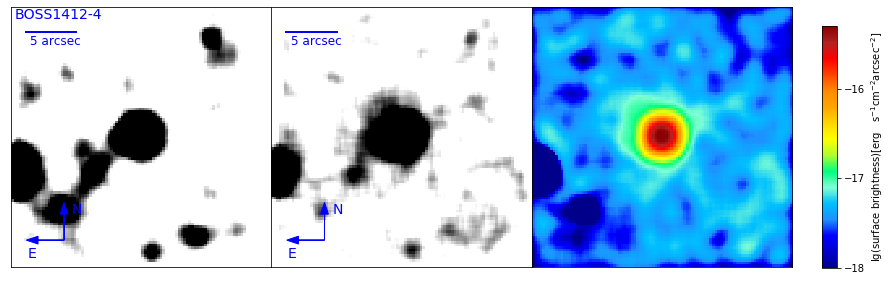

In [100]:
show_nebula_1412_4(smoothed_img_bw_1412_4,smoothed_img_nb_1412_4,sur_bri_lya_1412_4)

In [101]:
def Scaleimgconverter_nb_1412_5(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0.0015,vmax=0.0025)
    #norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm

def Scaleimgconverter_bw_1412_5(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0.02,vmax=0.03)
    return norm

def Scaleimgconverter_sb_1412_5(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-18,vmax=-15.3)
    return norm

In [102]:
kernel1412=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=7,y_size=7)
kernel_sb1412=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=11,y_size=11)

In [103]:
h_alpha_fits_nb_1412_5=fits.open('1412-5_nb.fits')
w_nb_1412_5 = WCS('1412-5_nb.fits')
data_nb_1412_5,header_nb_1412_5=fits.getdata('1412-5_nb.fits',header=True)
smoothed_img_nb_1412_5=convolve(data_nb_1412_5,kernel1412)

In [104]:
h_alpha_fits_bw_1412_5=fits.open('1412-5_bw.fits')
w_bw_1412_5 = WCS('1412-5_bw.fits')
data_bw_1412_5,header_bw_1412_5=fits.getdata('1412-5_bw.fits',header=True)
smoothed_img_bw_1412_5=convolve(data_bw_1412_5,kernel1412)

In [105]:
data_nb_p_1412_5=convert_to_positive(data_nb_1412_5)
data_bw_p_1412_5=convert_to_positive(data_bw_1412_5)

data_nb_seeing_1412_5=np.zeros(shape=(25,25))
data_bw_seeing_1412_5=np.zeros(shape=(25,25))


for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_nb_p_1412_5[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_nb_seeing_1412_5[k][l]=sum_cube
        sum_cube=0
        
for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_bw_p_1412_5[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_bw_seeing_1412_5[k][l]=sum_cube
        sum_cube=0

smoothed_img_nb_sb_1412_5=convolve(data_nb_1412_5,kernel_sb1412)
smoothed_img_bw_sb_1412_5=convolve(data_bw_1412_5,kernel_sb1412)   


In [106]:
def count_to_lya_sb_1412(img_bw,img_nb,lamda_bw=4135,delta_lamda_bw=1278,lamda_nb=4030,delta_lamda_nb=45,replacer=1e-10):
    
    mag_bw=-2.5*np.log10(img_bw)+26.354
    mag_nb=-2.5*np.log10(img_nb)+22.833
    
    flux_per_frequency_bw=10**(-(mag_bw+48.6)/2.5)
    flux_per_frequency_nb=10**(-(mag_nb+48.6)/2.5)
    
    flux_per_wavelength_bw=flux_per_frequency_bw*const.c.to(u.AA/u.second).value/(lamda_bw**2)
    flux_per_wavelength_nb=flux_per_frequency_nb*const.c.to(u.AA/u.second).value/(lamda_nb**2)
    
    flux_bw=flux_per_wavelength_bw*delta_lamda_bw*u.erg/(u.second*(u.cm**2))
    flux_nb=flux_per_wavelength_nb*delta_lamda_nb*u.erg/(u.second*(u.cm**2))
     
    flux_per_wavelength_cont=(flux_bw-flux_nb)/(delta_lamda_bw-delta_lamda_nb)
    flux_lya=flux_nb-flux_per_wavelength_cont*delta_lamda_nb
    sur_bri_lya=flux_lya/0.25/0.25
    
    return sur_bri_lya.value

In [107]:
sur_bri_lya_1412_5=count_to_lya_sb_1412(smoothed_img_bw_sb_1412_5,smoothed_img_nb_sb_1412_5)
for i in range(len(sur_bri_lya_1412_5)):
    for j in range(len(sur_bri_lya_1412_5[1])):
        if sur_bri_lya_1412_5[i][j]<0:
            sur_bri_lya_1412_5[i][j]=1e-100
        sur_bri_lya_1412_5[i][j]=math.log(sur_bri_lya_1412_5[i][j],10)

In [108]:
def show_nebula_1412_5(img1,img2,img3):
    fig = plt.figure(figsize=(14,14))

    ax1 = fig.add_subplot(131)
    norm1 = Scaleimgconverter_bw_1412_5(img1)
    ax1.imshow(img1,norm=norm1,cmap=plt.cm.gray_r)
    ax1.invert_yaxis()
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.text(1, 95, 'BOSS1412-5',fontsize=14, color = "blue")
    ax1.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax1.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax1.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax1.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax1.text(6, 3, 'E',fontsize=14, color = "blue")
    ax1.text(23, 20, 'N',fontsize=14, color = "blue")

    
    ax2 = fig.add_subplot(132)
    norm2 = Scaleimgconverter_nb_1412_5(img2)
    ax2.imshow(img2,norm=norm2,cmap=plt.cm.gray_r)
    ax2.invert_yaxis()
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax2.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax2.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax2.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax2.text(6, 3, 'E',fontsize=14, color = "blue")
    ax2.text(23, 20, 'N',fontsize=14, color = "blue")
    #ax2.set_title('$\mathregular{NB403}$',fontsize=16)
    
    ax3 = fig.add_subplot(133)
    norm3=Scaleimgconverter_sb_1412_5(img3)
    xx, yy = np.meshgrid(np.arange(0,len(img3[0])), np.arange(0, len(img3)))
    axzz=ax3.imshow(img3,norm=norm3,cmap=clrmap)
    #cset = ax3.contour(xx, yy, img3, [5e-18], colors='k')
    #ax3.clabel(cset, inline=0, fontsize=0)
    ax3.invert_yaxis()
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    
    #cb=plt.colorbar(axzz)
    
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0, hspace=None)
    
    fig.subplots_adjust(right=0.9)
    
    l = 0.93
    b = 0.373
    w = 0.015
    h = 0.24
    
    rect = [l,b,w,h] 
    cbar_ax = fig.add_axes(rect) 
    cb = plt.colorbar(axzz, cax=cbar_ax)
    cb.set_ticks([-18,-17,-16])
    cb.set_label('lg(surface brightness)[$\mathregular{erg\quad s^{-1} cm^{-2} arcsec^{-2}}$]')


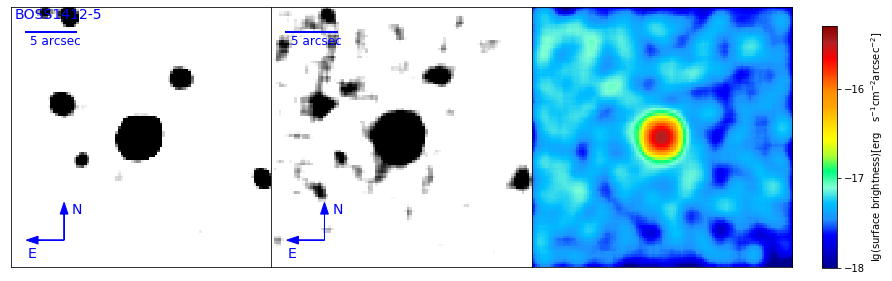

In [109]:
show_nebula_1412_5(smoothed_img_bw_1412_5,smoothed_img_nb_1412_5,sur_bri_lya_1412_5)

In [110]:
def Scaleimgconverter_nb_1412_6(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=0.0005,vmax=0.0015)
    #norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm

def Scaleimgconverter_bw_1412_6(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-0.005,vmax=0.005)
    return norm

def Scaleimgconverter_sb_1412_6(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch(),vmin=-18,vmax=-15.3)
    return norm

In [111]:
kernel1412=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=7,y_size=7)
kernel_sb1412=Gaussian2DKernel(x_stddev=3,y_stddev=3,x_size=11,y_size=11)

In [112]:
h_alpha_fits_nb_1412_6=fits.open('1412-6_nb.fits')
w_nb_1412_6 = WCS('1412-6_nb.fits')
data_nb_1412_6,header_nb_1412_6=fits.getdata('1412-6_nb.fits',header=True)
smoothed_img_nb_1412_6=convolve(data_nb_1412_6,kernel1412)

In [113]:
h_alpha_fits_bw_1412_6=fits.open('1412-6_bw.fits')
w_bw_1412_6 = WCS('1412-6_bw.fits')
data_bw_1412_6,header_bw_1412_6=fits.getdata('1412-6_bw.fits',header=True)
smoothed_img_bw_1412_6=convolve(data_bw_1412_6,kernel1412)

In [114]:
data_nb_p_1412_6=convert_to_positive(data_nb_1412_6)
data_bw_p_1412_6=convert_to_positive(data_bw_1412_6)

data_nb_seeing_1412_6=np.zeros(shape=(25,25))
data_bw_seeing_1412_6=np.zeros(shape=(25,25))


for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_nb_p_1412_6[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_nb_seeing_1412_6[k][l]=sum_cube
        sum_cube=0
        
for k in range(25):
    sum_cube=0
    for l in range(25):
        sumy=0
        for i in range(4):
            for j in range(4):
                sumy=sumy+data_bw_p_1412_6[k*4+i][l*4+j]
            sum_cube=sum_cube+sumy
            sumy=0
                
        data_bw_seeing_1412_6[k][l]=sum_cube
        sum_cube=0

smoothed_img_nb_sb_1412_6=convolve(data_nb_1412_6,kernel_sb1412)
smoothed_img_bw_sb_1412_6=convolve(data_bw_1412_6,kernel_sb1412)   


In [115]:
def count_to_lya_sb_1412(img_bw,img_nb,lamda_bw=4135,delta_lamda_bw=1278,lamda_nb=4030,delta_lamda_nb=45,replacer=1e-10):
    
    mag_bw=-2.5*np.log10(img_bw)+26.354
    mag_nb=-2.5*np.log10(img_nb)+22.833
    
    flux_per_frequency_bw=10**(-(mag_bw+48.6)/2.5)
    flux_per_frequency_nb=10**(-(mag_nb+48.6)/2.5)
    
    flux_per_wavelength_bw=flux_per_frequency_bw*const.c.to(u.AA/u.second).value/(lamda_bw**2)
    flux_per_wavelength_nb=flux_per_frequency_nb*const.c.to(u.AA/u.second).value/(lamda_nb**2)
    
    flux_bw=flux_per_wavelength_bw*delta_lamda_bw*u.erg/(u.second*(u.cm**2))
    flux_nb=flux_per_wavelength_nb*delta_lamda_nb*u.erg/(u.second*(u.cm**2))
     
    flux_per_wavelength_cont=(flux_bw-flux_nb)/(delta_lamda_bw-delta_lamda_nb)
    flux_lya=flux_nb-flux_per_wavelength_cont*delta_lamda_nb
    sur_bri_lya=flux_lya/0.25/0.25
    
    return sur_bri_lya.value

In [116]:
sur_bri_lya_1412_6=count_to_lya_sb_1412(smoothed_img_bw_sb_1412_6,smoothed_img_nb_sb_1412_6)
for i in range(len(sur_bri_lya_1412_6)):
    for j in range(len(sur_bri_lya_1412_6[1])):
        if sur_bri_lya_1412_6[i][j]<0:
            sur_bri_lya_1412_6[i][j]=1e-100
        sur_bri_lya_1412_6[i][j]=math.log(sur_bri_lya_1412_6[i][j],10)

In [117]:
def show_nebula_1412_6(img1,img2,img3):
    fig = plt.figure(figsize=(14,14))

    ax1 = fig.add_subplot(131)
    norm1 = Scaleimgconverter_bw_1412_6(img1)
    ax1.imshow(img1,norm=norm1,cmap=plt.cm.gray_r)
    ax1.invert_yaxis()
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.text(1, 95, 'BOSS1412-6',fontsize=14, color = "blue")
    ax1.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax1.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax1.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax1.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax1.text(6, 3, 'E',fontsize=14, color = "blue")
    ax1.text(23, 20, 'N',fontsize=14, color = "blue")

    
    ax2 = fig.add_subplot(132)
    norm2 = Scaleimgconverter_nb_1412_6(img2)
    ax2.imshow(img2,norm=norm2,cmap=plt.cm.gray_r)
    ax2.invert_yaxis()
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.hlines(y=90,xmin=5,xmax=25,lw=2,color='blue')
    ax2.text(7,85,'5 arcsec',fontsize=12,color='blue')
    ax2.arrow(20, 10, -10, 0, head_width=3,color='blue')
    ax2.arrow(20, 10, 0, 10, head_width=3,color='blue')
    ax2.text(6, 3, 'E',fontsize=14, color = "blue")
    ax2.text(23, 20, 'N',fontsize=14, color = "blue")
    #ax2.set_title('$\mathregular{NB403}$',fontsize=16)
    
    ax3 = fig.add_subplot(133)
    norm3=Scaleimgconverter_sb_1412_6(img3)
    xx, yy = np.meshgrid(np.arange(0,len(img3[0])), np.arange(0, len(img3)))
    axzz=ax3.imshow(img3,norm=norm3,cmap=clrmap)
    #cset = ax3.contour(xx, yy, img3, [5e-18], colors='k')
    #ax3.clabel(cset, inline=0, fontsize=0)
    ax3.invert_yaxis()
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    
    #cb=plt.colorbar(axzz)
    
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0, hspace=None)
    
    fig.subplots_adjust(right=0.9)
    
    l = 0.93
    b = 0.373
    w = 0.015
    h = 0.24
    
    rect = [l,b,w,h] 
    cbar_ax = fig.add_axes(rect) 
    cb = plt.colorbar(axzz, cax=cbar_ax)
    cb.set_ticks([-18,-17,-16])
    cb.set_label('lg(surface brightness)[$\mathregular{erg\quad s^{-1} cm^{-2} arcsec^{-2}}$]')


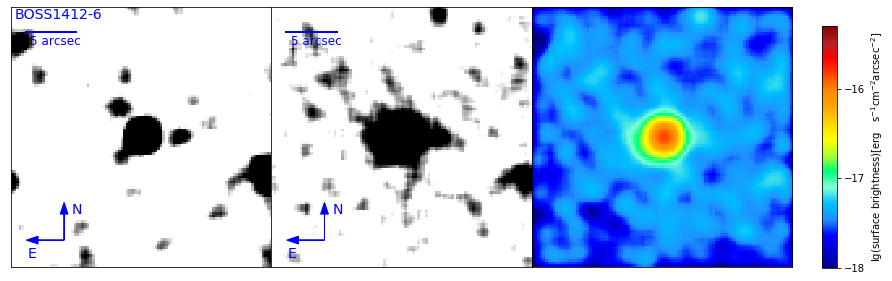

In [118]:
show_nebula_1412_6(smoothed_img_bw_1412_6,smoothed_img_nb_1412_6,sur_bri_lya_1412_6)